# Support Vector Machine And Artificial Neural Network MODEL.

<a href="https://colab.research.google.com/drive/1c6cIm1RpOjbQYXJ1rDGW-elbsKVcDSYB?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#https://towardsdatascience.com/walking-through-support-vector-regression-and-lstms-with-stock-price-prediction-45e11b620650

## Check Library

In [ ]:
#pip install tensorflow==2.6.0 --user
import tensorflow as tf
#tf.config.list_physical_devices('GPU')

In [5]:
'''
Error: cannot import name 'context' from 'tensorflow.python.eager' 
 $ conda install -c conda-forge keras

 $ conda install -c conda-forge tensorflow

 $ conda install -c anaconda tensorflow-gpu
'''
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
###
from platform import python_version
print(python_version())
import tensorflow as tf
print(tf.__version__)

Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]
Pandas 1.5.1
Scikit-Learn 1.1.3
GPU is NOT AVAILABLE
3.9.13
2.10.0


## Library

In [29]:
'''
Keras to create our neural network
pandas and pandas_data reader to get and analyze our stock data
datetime to fix our stock dates for data analysis
numpy to reshape our data to feed into our neural network
matplotlib to plot and visualize our data
warnings to ignore any of the unwanted warnings that pop up
'''
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.metrics import accuracy_score

!pip install pandas_datareader
import pandas_datareader.data as web
import datetime
import numpy as np
import pandas as pd 

from matplotlib import style

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

### GetData

In [ ]:
# Get the stock data using yahoo API:
style.use('ggplot')
# get 2014-2018 data to train our model
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2022,10,30)
df = web.DataReader("TSLA", 'yahoo', start, end)
# get 2019 data to test our model on 
start = datetime.datetime(2022,1,1)
end = datetime.date.today()
test_df = web.DataReader("TSLA", 'yahoo', start, end)

In [ ]:
# sort by date
df = df.sort_values('Date')
test_df = test_df.sort_values('Date')
# fix the date 
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)
test_df.reset_index(inplace=True)
test_df.set_index("Date", inplace=True)
df.tail()

In [9]:
test_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-12-31,360.666656,351.529999,357.813324,352.260010,40733700.0,352.260010
2022-01-03,400.356659,378.679993,382.583344,399.926666,103931400.0,399.926666
2022-01-04,402.666656,374.350006,396.516663,383.196655,100248300.0,383.196655
2022-01-05,390.113342,360.336670,382.216675,362.706665,80119800.0,362.706665
2022-01-06,362.666656,340.166656,359.000000,354.899994,90336600.0,354.899994
...,...,...,...,...,...,...
2022-11-14,195.729996,186.339996,192.770004,190.949997,92226600.0,190.949997
2022-11-15,200.820007,192.059998,195.880005,194.419998,91293800.0,194.419998
2022-11-16,192.570007,185.660004,191.509995,186.919998,66567600.0,186.919998


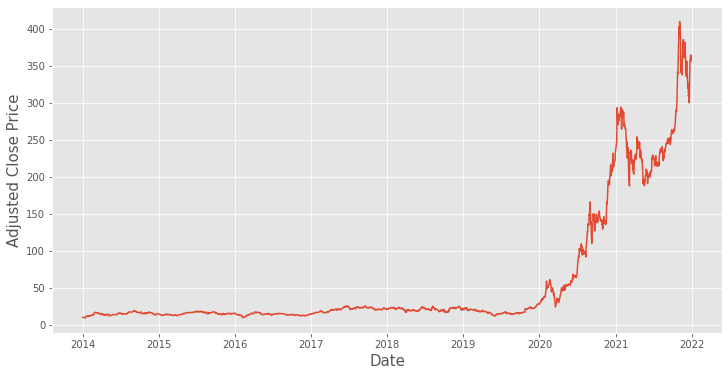

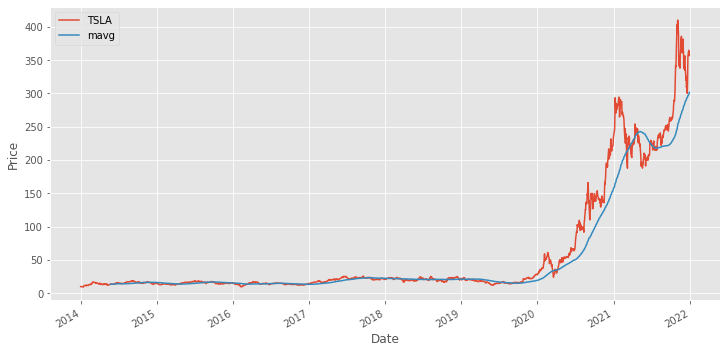

In [10]:
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(df["Adj Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Adjusted Close Price',fontsize=15)
plt.show()


# Rolling mean
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='TSLA')
mavg.plot(label='mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [11]:
import matplotlib.dates as mdates

# change the dates into ints for training 
dates_df = df.copy()
dates_df = dates_df.reset_index()

# Store the original dates for plotting the predicitons
org_dates = dates_df['Date']

# convert to ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
2010,18984.0,357.660004,332.519989,335.600006,355.666656,92713200.0,355.666656
2011,18988.0,372.333344,356.906677,357.890015,364.646667,71145900.0,364.646667
2012,18989.0,373.000000,359.473328,369.829987,362.823334,60324000.0,362.823334
2013,18990.0,368.000000,354.713318,366.213318,362.063324,56154000.0,362.063324
2014,18991.0,365.183319,351.049988,353.776672,356.779999,47040900.0,356.779999


# SVM model

In [ ]:
from sklearn.svm import SVR

# dates = dates_df['Date'].as_matrix()
# prices = df['Adj Close'].as_matrix()
# dates = dates_df['Date'].values()
# prices = df['Adj Close'].values()
dates = dates_df['Date'].to_numpy()
prices = df['Adj Close'].to_numpy()
#Convert to 1d Vector
dates = np.reshape(dates, (len(dates), 1))
prices = np.reshape(prices, (len(prices), 1))



# svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
# svr_rbf.fit(dates, prices)
###
for k in ['linear','poly','rbf','sigmoid']:
    clf = SVR(kernel=k,C=1e3,gamma=0.1)
    clf.fit(dates, prices)
    confidence = clf.score(dates, prices)
    print(k,confidence)
###

# svr_rbf_pre=svr_rbf.predict(dates)

# plt.figure(figsize = (12,6))
# plt.plot(dates, prices, color= 'black', label= 'Data')
# plt.plot(org_dates, svr_rbf_pre, color= 'red', label= 'RBF model') 

# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.show()

linear 0.28230207944012875


### Normalizing data:

In [13]:
df_svm=df
df_svm['svr_rbf_pre']=svr_rbf_pre
df_svm

,High,Low,Open,Close,Volume,Adj Close,svr_rbf_pre
Date,,,,,,,
2013-12-31,10.213333,9.910667,10.154667,10.028667,63936000.0,10.028667,10.128398
2014-01-02,10.165333,9.770000,9.986667,10.006667,92826000.0,10.006667,9.906592
2014-01-03,10.146000,9.906667,10.000000,9.970667,70425000.0,9.970667,10.070237
2014-01-06,10.026667,9.682667,10.000000,9.800000,80416500.0,9.800000,9.737449
2014-01-07,10.026667,9.683333,9.841333,9.957333,75511500.0,9.957333,10.057354
...,...,...,...,...,...,...,...
2021-12-23,357.660004,332.519989,335.600006,355.666656,92713200.0,355.666656,355.566478
2021-12-27,372.333344,356.906677,357.890015,364.646667,71145900.0,364.646667,364.547106
2021-12-28,373.000000,359.473328,369.829987,362.823334,60324000.0,362.823334,362.723243


In [14]:
prices

array([[ 10.02866745],
       [ 10.00666714],
       [  9.97066689],
       ...,
       [362.82333374],
       [362.06332397],
       [356.77999878]])

In [15]:
svm_confidence = svr_rbf.score(prices, svr_rbf_pre)
svm_confidence

-2.366320912772224e-06

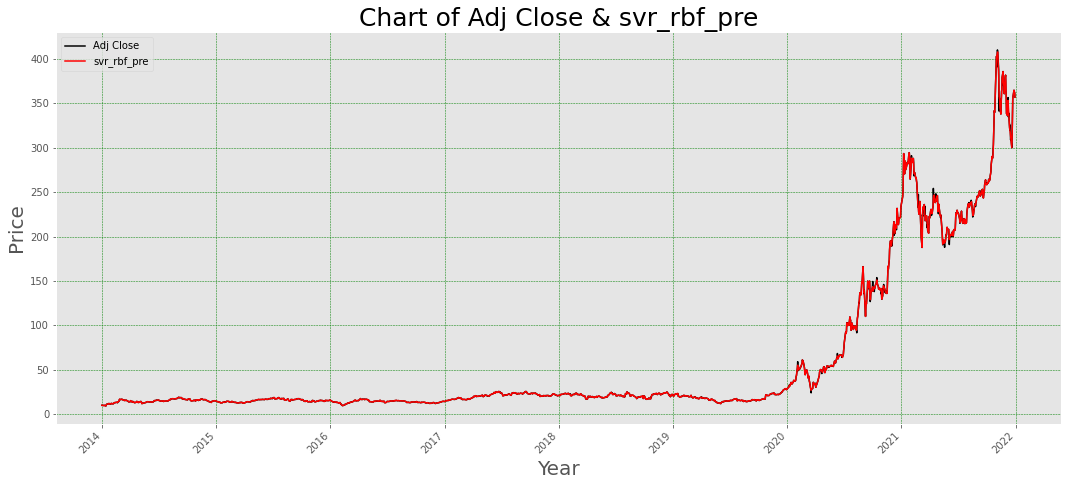

In [16]:
def plot_x_y(x, name_of_x, y, name_of_y):
    fig, ax = plt.subplots(figsize=(18, 8))
    ax.plot(x, label=name_of_x, color= 'black')
    ax.plot(y, label=name_of_y, color= 'red')
    ax.set_xlabel('Year', fontsize=20)
    ax.set_ylabel('Price', fontsize=20)
    fig.autofmt_xdate(rotation=45)
    ax.set_title('Chart of ' + name_of_x + ' & ' + name_of_y,
                 fontsize=25)
    ax.grid(color='green', linestyle='--', linewidth=0.5)
    ax.legend()
    fig.show()
plot_x_y(df_svm['Adj Close'],'Adj Close',df_svm['svr_rbf_pre'],'svr_rbf_pre')

## insert data for ANN

In [17]:
# Create train set of adj close prices data:
#train_data = df.loc[:,'Adj Close'].as_matrix()
train_data = df.loc[:,'Adj Close'].to_numpy()
print(train_data.shape) # 1258 
# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
scaler.fit(train_data)
train_data = scaler.transform(train_data)
train_data

(2015,)


array([[0.0018452 ],
       [0.00179029],
       [0.00170044],
       ...,
       [0.88233356],
       [0.88043676],
       [0.86725089]])

- Ở đây chúng ta tạo ra chức năng 'create_dataset'. Hàm này lặp lại từ (0 đến độ dài tập dữ liệu của chúng ta — số bước thời gian).\
- Vì vậy, về cơ bản mỗi chỉ số trong mảng X_train chứa một mảng gồm 36 ngày giá đóng cửa và mảng y_train chứa giá đóng cửa một ngày sau các bước thời gian\
- Vì vậy, nói cách khác,cung cấp cho mạng nơ-ron 36 ngày so với giá đóng cửa trước đó của dữ liệu cổ phiếu và sau đó để nó dự đoán vào ngày tiếp theo của giá cổ phiếu đóng cửa.

In [18]:
'''Function to create a dataset to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    
# Create the data to train model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)
# Visualizing  data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(1979, 36, 1)
X_train:
[[10.02866745]
 [10.00666714]
 [ 9.97066689]
 [ 9.80000019]
 [ 9.95733261]
 [10.08533287]
 [ 9.83533287]
 [ 9.71466732]
 [ 9.28933334]
 [10.75133324]
 [10.94200039]
 [11.39799976]
 [11.33399963]
 [11.77866745]
 [11.90400028]
 [12.10000038]
 [11.64000034]
 [11.30799961]
 [11.8920002 ]
 [11.68200016]
 [12.18933296]
 [12.09399986]
 [11.80733299]
 [11.91533279]
 [11.62800026]
 [11.8920002 ]
 [12.43533325]
 [13.10400009]
 [13.1079998 ]
 [13.02133274]
 [13.30866718]
 [13.21533298]
 [13.57999992]
 [12.90933323]
 [13.99800014]
 [13.97333336]]


y_train: [[14.51000023]]



# ANN MODEL
## Recurrent Neural Networks:

- LSTM là viết tắt của Long Short Term Memory. LSTM là một phiên bản nâng cao của mạng nơ-ron tái phát. Mạng nơ-ron tái phát (RNN) là một loại mạng nơ-ron đặc biệt. RNN lấy đầu ra trước đó làm đầu vào. Trong RNN, đầu ra trước đó ảnh hưởng đến đầu ra tiếp theo.

In [19]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Epoch 1/20
139/139 [==============================] - 16s 63ms/step - loss: 2.5176e-05 - val_loss: 0.0025
Epoch 2/20
139/139 [==============================] - 8s 60ms/step - loss: 1.1827e-05 - val_loss: 0.0046
Epoch 3/20
139/139 [==============================] - 10s 75ms/step - loss: 1.1135e-05 - val_loss: 0.0019
Epoch 4/20
139/139 [==============================] - 7s 49ms/step - loss: 9.4579e-06 - val_loss: 0.0020
Epoch 5/20
139/139 [==============================] - 7s 51ms/step - loss: 7.3808e-06 - val_loss: 0.0044
Epoch 6/20
139/139 [==============================] - 7s 49ms/step - loss: 7.7011e-06 - val_loss: 0.0013
Epoch 7/20
139/139 [==============================] - 7s 51ms/step - loss: 7.6968e-06 - val_loss: 0.0047
Epoch 8/20
139/139 [==============================] - 7s 50ms/step - loss: 7.3496e-06 - val_loss: 9.9323e-04
Epoch 9/20
139/139 [==============================] - 7s 51ms/step - loss: 6.1637e-06 - val_loss: 8.0730e-04
Epoch 10/20
139/139 [========================

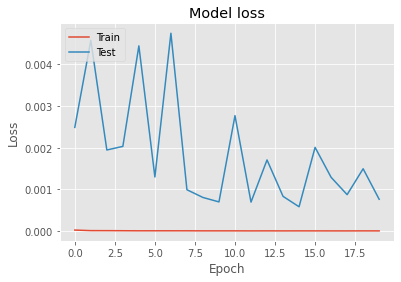

In [20]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Predict

6/6 [==============================] - 2s 36ms/step


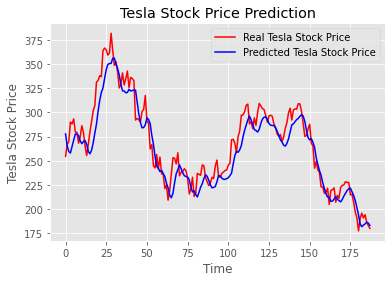

In [21]:
# Get the stock prices for 2019 to have our model make the predictions
test_data = test_df['Adj Close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)
# plot the results 
plt.plot(org_y, color = 'red', label = 'Real Tesla Stock Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

In [22]:
org_y.shape

(188, 1)

In [23]:
predicted_y.shape

(188, 1)

In [24]:
start = datetime.datetime(2022,9,15)
end = datetime.date.today()
price_Tes = web.DataReader("TSLA", 'yahoo', start, end)
price_Tes

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-14,306.000000,291.640015,292.239990,302.609985,72628700,302.609985
2022-09-15,309.119995,300.720001,301.829987,303.750000,64795500,303.750000
2022-09-16,303.709991,295.600006,299.609985,303.350006,87087800,303.350006
2022-09-19,309.839996,297.799988,300.089996,309.070007,60231200,309.070007
2022-09-20,313.329987,305.579987,306.910004,308.730011,61642800,308.730011
2022-09-21,313.799988,300.630005,308.290009,300.799988,62555700,300.799988
2022-09-22,301.290009,285.820007,299.859985,288.589996,70545400,288.589996
2022-09-23,284.500000,272.820007,283.089996,275.329987,63748400,275.329987
2022-09-26,284.089996,270.309998,271.829987,276.010010,58076900,276.010010
